#**Geocoding Existing Mobile Home Parks (MHP) in Los Angeles County**

This notebook goes through the process of geocoding the mobile home park dataset from LA County. Since our data only included addresses, we will need to convert the addresses to geographic coordinates.

**Import Libraries**

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as ctx
import plotly.express as px
import pandas as pd

In [2]:
mhp = pd.read_csv( 'Data/CAHCD_1026.csv')

**Data Exploration**

In [3]:
mhp.head()

,Park Name,County,Park Identifier,Park Address,City,Zip,Phone,Fire Authority,Jurisdiction,MH Spaces,RV Lots W/Drains,RV Lots W/O Drains,Operated by
0,IMPERIAL TRAILER PARK,LOS ANGELES,13-0018-MP,"600 N IMPERIAL AVE, HAWTHORNE, CA 90250",HAWTHORNE,90250,NaN,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","IMPERIAL COUNTY BUILDING DEPARTMENT, 801 MAIN ...",8,0,0,"HOLCOM, BRADLEY, PO BOX 3162, SAN DIEGO, CA 92163"
1,CHETS TRAILER PARK,LOS ANGELES,19-0001-MP,"4630 W ROSECRANS AVE , LAWNDALE, CA 90260",LAWNDALE,90260,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",49,0,0,"DOSHI, NAVINCHANDRA, 6418 SPRING PARK AVE, LOS..."
2,A & A MOBILE HOME PARK,LOS ANGELES,19-0003-MP,"7722 ATLANTIC BLVD, CUDAHY, CA 90201",CUDAHY,90201,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",21,0,0,"A & A MHP LLC, 26895 ALISO CREEK RD #B876, ALI..."
3,ACE TRAILER PARK,LOS ANGELES,19-0006-MP,"6508 FLORENCE PL, BELL GARDENS, CA 90201",BELL GARDENS,90201,(213) 927-2868,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",8,0,0,"LUELLA PERDEW REVOCABLE TRUST, PO BOX 3259, WI..."
4,ACORN TP,LOS ANGELES,19-0009-MP,"2818 DURFEE AVE, EL MONTE, CA 91732",EL MONTE,91732,(818) 350-5235,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",20,0,0,"PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR..."


**Trim the Data**

In [4]:
mhp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Park Name           596 non-null    object
 1   County              596 non-null    object
 2   Park Identifier     596 non-null    object
 3   Park Address        596 non-null    object
 4   City                596 non-null    object
 5   Zip                 596 non-null    object
 6   Phone               586 non-null    object
 7   Fire Authority      596 non-null    object
 8   Jurisdiction        596 non-null    object
 9   MH Spaces           596 non-null    int64 
 10  RV Lots W/Drains    596 non-null    int64 
 11  RV Lots W/O Drains  596 non-null    int64 
 12  Operated by         595 non-null    object
dtypes: int64(3), object(10)
memory usage: 60.7+ KB


*Because the dataset doesn't have accessive columns, I will keep them in case I want to explore with them later for another analysis*

**Add the lat/lon columns**

This command will allow me to add empty lat/lon columns to our dataframe as placeholders for the geocoding.

In [5]:
mhp['lat'] = pd.Series(dtype='float')
mhp['lon'] = pd.Series(dtype='float')

In [6]:
mhp.head()

,Park Name,County,Park Identifier,Park Address,City,Zip,Phone,Fire Authority,Jurisdiction,MH Spaces,RV Lots W/Drains,RV Lots W/O Drains,Operated by,lat,lon
0,IMPERIAL TRAILER PARK,LOS ANGELES,13-0018-MP,"600 N IMPERIAL AVE, HAWTHORNE, CA 90250",HAWTHORNE,90250,NaN,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","IMPERIAL COUNTY BUILDING DEPARTMENT, 801 MAIN ...",8,0,0,"HOLCOM, BRADLEY, PO BOX 3162, SAN DIEGO, CA 92163",NaN,NaN
1,CHETS TRAILER PARK,LOS ANGELES,19-0001-MP,"4630 W ROSECRANS AVE , LAWNDALE, CA 90260",LAWNDALE,90260,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",49,0,0,"DOSHI, NAVINCHANDRA, 6418 SPRING PARK AVE, LOS...",NaN,NaN
2,A & A MOBILE HOME PARK,LOS ANGELES,19-0003-MP,"7722 ATLANTIC BLVD, CUDAHY, CA 90201",CUDAHY,90201,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",21,0,0,"A & A MHP LLC, 26895 ALISO CREEK RD #B876, ALI...",NaN,NaN
3,ACE TRAILER PARK,LOS ANGELES,19-0006-MP,"6508 FLORENCE PL, BELL GARDENS, CA 90201",BELL GARDENS,90201,(213) 927-2868,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",8,0,0,"LUELLA PERDEW REVOCABLE TRUST, PO BOX 3259, WI...",NaN,NaN
4,ACORN TP,LOS ANGELES,19-0009-MP,"2818 DURFEE AVE, EL MONTE, CA 91732",EL MONTE,91732,(818) 350-5235,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",20,0,0,"PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...",NaN,NaN


**Loop & geocode**

Now that I have added the columns, I can begin geocoding. First I will loop through list and add to dataframe with lat/lon's

In [9]:
for index, row in mhp.iterrows():

    # identify the address column
    address = row['Park Address']
    
    try:
        
        # geocode it
        geocoded_address = ox.geocoder.geocode(address)

        # add it to the dataframe
        mhp.at[index,'lat']=geocoded_address[0]
        mhp.at[index,'lon']=geocoded_address[1]

        # print the output
        print(address + ' geocoded to ' + str(geocoded_address[0])+' '+str(geocoded_address[1]))        

    except:
        print('Could not geocode '+ address)
        pass

Could not geocode 600 N IMPERIAL AVE,  HAWTHORNE,  CA 90250
4630 W ROSECRANS AVE ,  LAWNDALE,  CA 90260 geocoded to 33.90181650383147 -118.35784749424559
Could not geocode 7722 ATLANTIC BLVD,  CUDAHY,  CA 90201
6508 FLORENCE PL,  BELL GARDENS,  CA 90201 geocoded to 33.96612797698378 -118.1493402429194
2818 DURFEE AVE,  EL MONTE,  CA 91732 geocoded to 34.05611618169685 -118.01700161824057
Could not geocode 3740 SMITH ST,  ACTON,  CA 93510
Could not geocode 2730 N CHICO AVE,  S EL MONTE,  CA 91733
Could not geocode 3905 W IMPERIAL HWY,  INGLEWOOD,  CA 90303
Could not geocode 15012 LEMOLI AVE,  GARDENA,  CA 90249
Could not geocode 1422 E ROSECRANS,  COMPTON,  CA 90220
Could not geocode 43667 TR. K ELIZABETH LAKE,  LAKE HUGHES,  CA 93532
812 N LOREN AVE,  AZUSA,  CA 91702 geocoded to 34.13640459183674 -117.92365224489797
11250 PLAYA ST,  CULVER CITY,  CA 90230 geocoded to 33.99214527152518 -118.3918554727561
Could not geocode 8807 E PALMDALE BLVD,  PALMDALE,  CA 93550
4345 ROSECRANS AVE,  

In [10]:
mhp

,Park Name,County,Park Identifier,Park Address,City,Zip,Phone,Fire Authority,Jurisdiction,MH Spaces,RV Lots W/Drains,RV Lots W/O Drains,Operated by,lat,lon
0,IMPERIAL TRAILER PARK,LOS ANGELES,13-0018-MP,"600 N IMPERIAL AVE, HAWTHORNE, CA 90250",HAWTHORNE,90250,NaN,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","IMPERIAL COUNTY BUILDING DEPARTMENT, 801 MAIN ...",8,0,0,"HOLCOM, BRADLEY, PO BOX 3162, SAN DIEGO, CA 92163",NaN,NaN
1,CHETS TRAILER PARK,LOS ANGELES,19-0001-MP,"4630 W ROSECRANS AVE , LAWNDALE, CA 90260",LAWNDALE,90260,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",49,0,0,"DOSHI, NAVINCHANDRA, 6418 SPRING PARK AVE, LOS...",33.901817,-118.357847
2,A & A MOBILE HOME PARK,LOS ANGELES,19-0003-MP,"7722 ATLANTIC BLVD, CUDAHY, CA 90201",CUDAHY,90201,(310) 676-0663,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",21,0,0,"A & A MHP LLC, 26895 ALISO CREEK RD #B876, ALI...",NaN,NaN
3,ACE TRAILER PARK,LOS ANGELES,19-0006-MP,"6508 FLORENCE PL, BELL GARDENS, CA 90201",BELL GARDENS,90201,(213) 927-2868,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",8,0,0,"LUELLA PERDEW REVOCABLE TRUST, PO BOX 3259, WI...",33.966128,-118.149340
4,ACORN TP,LOS ANGELES,19-0009-MP,"2818 DURFEE AVE, EL MONTE, CA 91732",EL MONTE,91732,(818) 350-5235,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",20,0,0,"PATTERSON, GLEN, PO BOX 1811, MYRTLE CREEK, OR...",34.056116,-118.017002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,LACO MHP,LOS ANGELES,19-1572-MP,"22325 S MAIN ST, CARSON, CA 90745",CARSON,90745,(818) 285-9823,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",94,0,0,"CARSON MHP ASSOCIATES LP, 320 N PARK VISTA ST,...",33.846183,-118.280073
592,VILLAGE MHP,LOS ANGELES,19-1574-MP,"17100 S GRAMERCY PL, GARDENA, CA 90247",GARDENA,90247,(310) 329-0115,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",50,0,0,"GARDENA NONPROFIT HOMES INC, C/O LES FRAME ENT...",NaN,NaN
593,WALNUT PARK,LOS ANGELES,19-1575-MP,"19130 NORDHOFF ST, NORTHRIDGE, CA 91324",NORTHRIDGE,91324,(562) 434-9195,"HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",0,114,0,"WILLIAMS, CAROL, 444 WEST OCEAN BLVD SUITE # 8...",34.235403,-118.550639
594,DELSUR GARDENS TP,LOS ANGELES,19-1576-MP,"9020 W AVE J, LANCASTER, CA 93536",LANCASTER,93536,(805) 943-5434,"COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...","HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...",0,42,0,"LEE, YANG, PO BOX 74771, LOS ANGELES, CA 90004",34.689391,-118.191614


I can see **most** of the addresses were successfully geocoded

**Convert to geodataframe**

The resulting table is a pandas dataframe. I'll convert it to a geodataframe. Since the addresses were geocoded to their latitude and longitude coordinates, I'll specify here to use the WGS84 geographic coordinate system using EPSG: 4326

In [11]:
# convert pandas dataframe to geodataframe
mhp = gpd.GeoDataFrame(mhp, 
                                     crs="EPSG:4326",
                                     geometry=gpd.points_from_xy(mhp.lon, mhp.lat))

**Add base layer capability**

Next, I'll project it to a web mercator projection to allow contextily titles to work as a base layer

In [12]:
# reproject to web mercator
mhp = mhp.to_crs(epsg=3857)

**Map Time!** :smile:

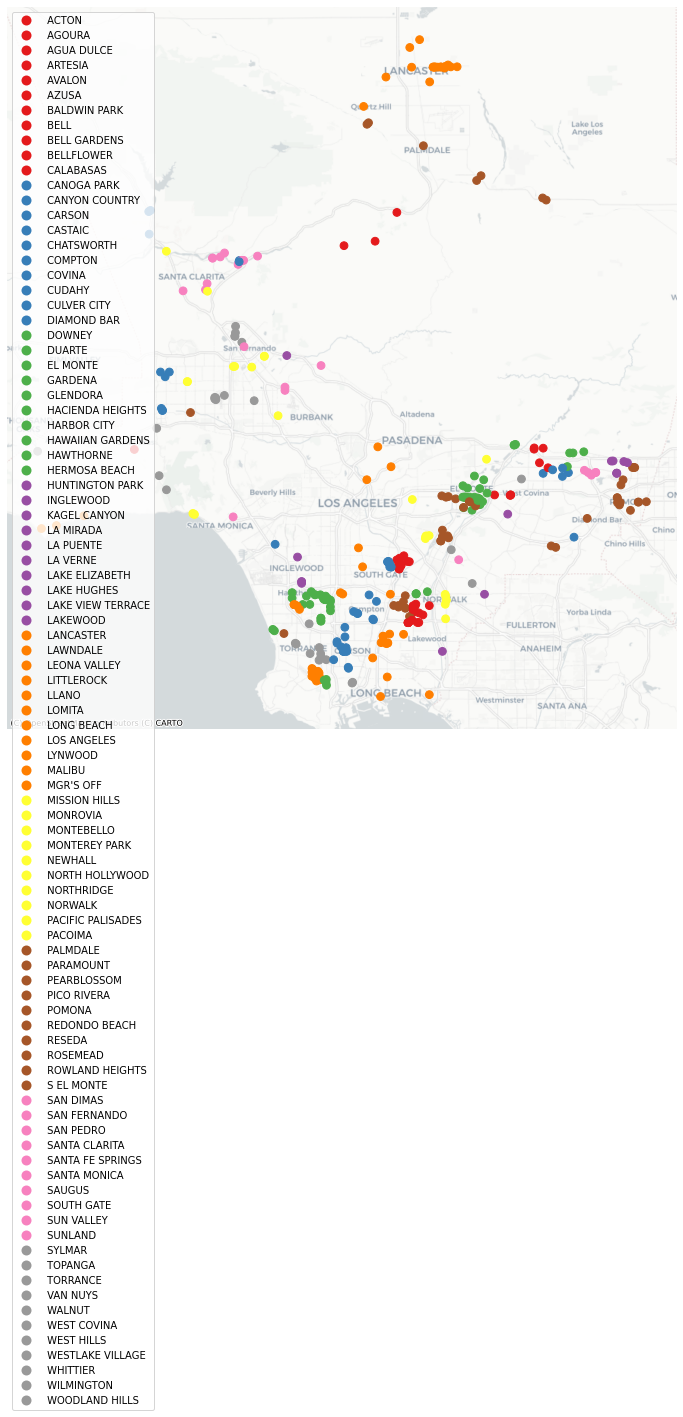

In [16]:
ax = mhp.plot(figsize=(12,20),
                              column='City',
                              legend=True,
                              cmap='Set1',
                             markersize=60)

ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now, my map doesn't look as clear as I'd like. It's helpful to know every city but there are areas of concentration, and the overlaps take away from the map. Geocoding was helpful because it gave me a visual of our data, and that in turn will help me think about next steps. I also have to consider that the command didn't geocode all the addresses- so 